1. Introduction
Provide an overview of the objective: Segmenting nuclei in a 3D image stack.
Briefly describe Cellpose and why it’s used for segmentation.
Link to any relevant resources, including the 10x Genomics guide.

3. Import Libraries
python
Copy code


In [1]:
import tifffile
import matplotlib.pyplot as plt
from cellpose import models, io
import numpy as np
from skimage.transform import rescale


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/rasools/miniconda3/envs/cellpose_env/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/rasools/miniconda3/envs/cellpose_env/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/rasools/miniconda3/envs/cellpose_env/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/rasools/miniconda3/envs/cellpose_env/lib/python3.9/site-packages/traitlets

### Load and Explore the 3D Image Data
Load the .tif image stack and visualize a few slices to understand the structure of the data.

In [ ]:
# Load the 3D image
image_path = 'data/xenium_2.0.0_io/morphology.ome.tif'
image_stack = tifffile.imread(image_path)

# Display the original dimensions of the image stack
print("Original image stack dimensions (slices, height, width):", image_stack.shape)

# Display a few slices to explore the data
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, slice_idx in enumerate([0, len(image_stack)//2, -1]):
    axes[i].imshow(image_stack[slice_idx], cmap='gray')
    axes[i].set_title(f'Slice {slice_idx}')
    axes[i].axis('off')
plt.show()


### Select a Smaller Volume of Interest
Choose a subset of slices and a specific region within each slice.

Selected volume dimensions (slices, height, width): (1, 5000, 5000)


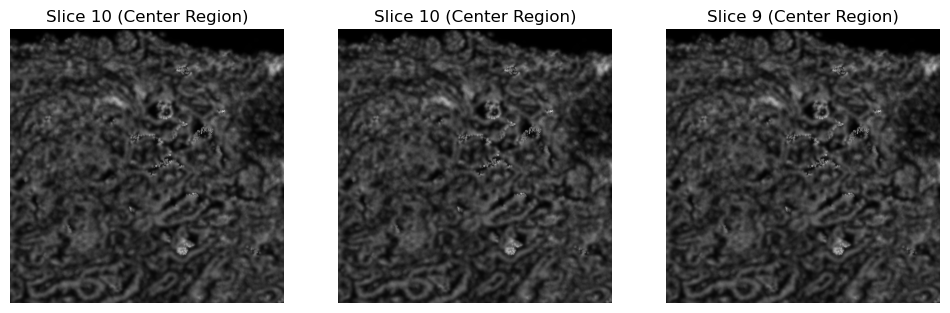

In [ ]:
# Define parameters for volume of interest
start_slice = 10         # Starting slice index
end_slice = 20           # Ending slice index

# Calculate the center coordinates and define a region around the center
height, width = image_stack.shape[1], image_stack.shape[2]
center_y, center_x = height // 2, width // 2
crop_size = 500  # Size of the square region to extract (adjust as needed)

# Define the cropping boundaries around the center
y_start = center_y - crop_size // 2
y_end = center_y + crop_size // 2
x_start = center_x - crop_size // 2
x_end = center_x + crop_size // 2

# Select the smaller volume of interest from the center of each slice
volume_of_interest = image_stack[start_slice:end_slice, y_start:y_end, x_start:x_end]
print("Selected volume dimensions (slices, height, width):", volume_of_interest.shape)

# Display a few slices of the selected volume
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, slice_idx in enumerate([0, len(volume_of_interest)//2, -1]):
    axes[i].imshow(volume_of_interest[slice_idx], cmap='gray')
    axes[i].set_title(f"Slice {slice_idx + start_slice} (Center Region)")
    axes[i].axis('off')
plt.show()



### Set Up the Cellpose Model for Segmentation
Load the Cellpose model for nucleus segmentation and define parameters.

In [ ]:
# Load Cellpose model for nuclei segmentation
model = models.Cellpose(gpu=False, model_type='nuclei')  # Use gpu=False if no GPU available

# Define segmentation parameters
diameter = 10  # Adjust based on the size of the nuclei
channels = [0, 0]  # Grayscale images typically use [0, 0]


### Perform Segmentation on the Selected Volume
Run Cellpose segmentation on the selected volume of interest.